In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import random
import parallelproj
from scipy.ndimage import gaussian_filter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


              -  -  -  -  -  -  -  -   -  -  -  -
              P  A  R  A  L  L  E  L | P  R  O  J
              -  -  -  -  -  -  -  -   -  -  -  -


             Please consider citing our publication
          ---------------------------------------------
          Georg Schramm and Kris Thielemans:
          "PARALLELPROJ—an open-source framework for
           fast calculation of projections in
           tomography"
          Front. Nucl. Med., 08 January 2024
          Sec. PET and SPECT, Vol 3
          https://doi.org/10.3389/fnume.2023.1324562

 
        parallelproj C    lib         ..: C:\Users\melis\anaconda3\envs\parallelproj-env\Library\bin\parallelproj_c.dll
        parallelproj CUDA lib         ..: None
        parallelproj CUDA kernel file ..: None
        parallelproj CUDA present     ..: False
        parallelproj cupy enabled     ..: False
        


In [2]:
# Random seed for reproducibility 
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


In [3]:
def normalize(image):
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()  #Convert to NumPy if it's a tensor
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def normalize_together(image1, image2):
    if isinstance(image1, torch.Tensor):
        image1 = image1.cpu().numpy()
    if isinstance(image2, torch.Tensor):
        image2 = image2.cpu().numpy()

    #find the global min and max across both images
    global_min = min(np.min(image1), np.min(image2))
    global_max = max(np.max(image1), np.max(image2))

    #normalize each image using the global min/max
    image1_norm = (image1 - global_min) / (global_max - global_min)
    image2_norm = (image2 - global_min) / (global_max - global_min)

    return image1_norm, image2_norm


In [4]:
# Parameters 
num_samples = 5000
img_size = (128, 128)
detector_bins = 128

r = np.linspace(-1, 1, img_size[0])
theta = np.linspace(0, np.pi, detector_bins, endpoint=False)  #Projection angles

#Projection Operator 
proj = parallelproj.ParallelViewProjector2D(
    (detector_bins, detector_bins), r, -theta,
    2 * float(np.max(r)), (float(np.min(r)), float(np.min(r))),
    (float(r[1] - r[0]), float(r[1] - r[0]))
)

In [5]:
image_size = (128,128)

def draw_ellipse(image, mask, center, axes, intensity, label, angle):
    yy, xx = np.indices(image.shape)
    cy, cx = center
    ry, rx = axes  # major and minor axes

    theta = np.radians(angle)

    #rotate coordinates around ellipse center
    x_rot = (xx - cx) * np.cos(theta) + (yy - cy) * np.sin(theta)
    y_rot = -(xx - cx) * np.sin(theta) + (yy - cy) * np.cos(theta)

    # wllipse equation
    ellipse_region = (x_rot**2 / rx**2 + y_rot**2 / ry**2) <= 1

    # Blend overlapping intensities by averaging
    existing_mask = image > 0
    image[ellipse_region] = (image[ellipse_region] + intensity) / (existing_mask[ellipse_region] + 1)

    # Assign segmentation labels
    mask[ellipse_region] = label  #soft tissue = 1, bone = 2

def generate_pet_image(shape=image_size, num_ellipses=5):  

    img = torch.zeros(shape, dtype=torch.float32, device=device)
    mask = torch.zeros(shape, dtype=torch.float32, device=device)  #Segmentation mask
    height, width = shape
    
    soft_tissue_range=(1.5, 3.0)
    bone_range=(0.5, 1.5)
    soft_tissue_ratio=0.7

    num_soft_tissue = int(num_ellipses * soft_tissue_ratio)  # majority is soft tissue

    ellipses = []  #Store ellipse properties for distance checking

    for i in range(num_ellipses):
        valid_position = False
        attempts = 0

        while not valid_position and attempts < 50:
            #Random center, avoiding borders
            center = (random.randint(30, width - 30), random.randint(30, height - 30))

            #Generate axes with more natural aspect ratios
            axis_ratio = random.uniform(1.2, 2.5)  # More diverse aspect ratios
            major_axis = random.randint(15, 35)
            minor_axis = int(major_axis / axis_ratio)

            axes = (major_axis, minor_axis)
            angle = random.uniform(0, 180)  # random rotation angle

            if i < num_soft_tissue:
                intensity = random.uniform(*soft_tissue_range)  
                label = 1  # Soft Tissue
            else:
                intensity = random.uniform(*bone_range)  
                label = 2  # Bone

            # not overlap too much 
            valid_position = all(
                np.linalg.norm(np.array(center) - np.array(e[0])) > (0.6 * (axes[0] + e[1][0]))
                for e in ellipses
            )

            if valid_position:
                ellipses.append((center, axes, intensity, label, angle))

            attempts += 1

    # Draw ellipses and assign labels
    for center, axes, intensity, label, angle in ellipses:
        draw_ellipse(img, mask, center, axes, intensity, label, angle)

    return img, mask



In [6]:


def generate_ct_image(segmentation_mask):
    
    air_value=-1000 
    soft_tissue_value=40 #(Hu)
    bone_value=1000
    
    # initialize CT image with the lowest attenuation
    ct_image = torch.full_like(segmentation_mask, air_value, dtype=torch.float32)
    
    # apply attenuation values
    ct_image[segmentation_mask == 1] = soft_tissue_value  
    ct_image[segmentation_mask == 2] = bone_value         

    return ct_image


In [7]:
def ct_to_attenuation(ct_image):
    """
    Converts CT Hounsfield Units (HU) to PET attenuation coefficients (μ-values)
    using a linear approximation.

    Parameters:
        ct_image (numpy.ndarray): CT image in HU
        a (float): Conversion factor for HU to PET μ-values (default = 9.6e-5)
        b (float): Baseline PET attenuation coefficient (default = 0.096)

    Returns:
        Attenuation map
    """
    a=9.6e-5 
    b=0.096
    # Convert HU to PET attenuation coefficients (μ-values)
    attenuation_map = a * ct_image + b

    # Ensure non-negative values
    attenuation_map[attenuation_map < 0] = 0

    return attenuation_map


In [8]:
def apply_attenuation_correction(pet_image, attenuation_map):

    path_length=5
    pet_sinogram = proj(pet_image)
    attenuation_sinogram = proj(attenuation_map)
    # Step 2: Compute attenuation correction factors
    attenuation_factors = np.exp(attenuation_sinogram*path_length)  # Correction factor: exp(μ-integral)

    # Step 3: Apply attenuation correction to the sinogram
    corrected_sinogram = pet_sinogram * attenuation_factors

    return corrected_sinogram


In [9]:
def add_tumors(pet_without_tumors, pet_segmentation, num_tumors=3):
    """
    Adds tumors to the PET image, ensuring they are placed inside anatomical structures
    (soft tissue or bone) and have the highest intensity.
    """

    pet_without_tumors = pet_without_tumors.clone().detach().to(dtype=torch.float32)
    pet_segmentation = pet_segmentation.clone().detach().to(dtype=torch.int32)


    shape = pet_without_tumors.shape
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(-1, 1, shape[0]),
        torch.linspace(-1, 1, shape[1]),
        indexing="ij"
    )

    anatomy_mask = (pet_segmentation > 0)  # Only soft tissue (1) & bone (2)

    for _ in range(num_tumors):
        valid_x, valid_y = torch.where(anatomy_mask)  
        if valid_x.numel() == 0: 
            continue  

        # Randomly pick a tumor center inside valid anatomy
        idx = np.random.randint(0, valid_x.numel())
        center = torch.tensor([
            (valid_x[idx].item() / shape[0]) * 2 - 1, 
            (valid_y[idx].item() / shape[1]) * 2 - 1
        ])

        # Tumor size varies but stays within bounds
        radii = torch.tensor([
            np.random.uniform(0.03, 0.07),  
            np.random.uniform(0.03, 0.07)
        ])
        
        # Define tumor mask using an ellipse equation
        tumor = (((grid_x - center[0]) / radii[0]) ** 2 + ((grid_y - center[1]) / radii[1]) ** 2) <= 1
        tumor = tumor & anatomy_mask  # Ensure tumor stays inside valid areas

        if tumor.sum() == 0:  
            continue

        # Assign maximum intensity to tumors (1.5× max PET intensity)
        tumor_intensity = 7  
        pet_without_tumors[tumor] = tumor_intensity  

        # Mark tumor in segmentation mask (e.g., label 99)
        pet_segmentation[tumor] = 99  

    # Convert back to NumPy
    return pet_without_tumors.numpy(), pet_segmentation.numpy()

In [10]:

# Function to add contamination (simulating scatter & random background events)
def add_contamination(image, contamination_factor=0.1):
    if isinstance(image, np.ndarray):  
        image = torch.tensor(image, dtype=torch.float32)

    contamination = contamination_factor * torch.mean(image) * torch.ones_like(image)
    return image + contamination

# Function to apply Gaussian blurring (simulating scanner resolution)
def apply_blurring(image, sigma=1.5):
    image_np = image.cpu().numpy()
    blurred = gaussian_filter(image_np, sigma=sigma)  
    return torch.tensor(blurred, dtype=torch.float32, device=image.device)

# Function to add Poisson noise (simulating photon counting statistics)
def add_poisson_noise(image, scale_factor=1000):
    image_np = image.cpu().numpy()
    image_scaled = image_np * scale_factor  
    pet_noisy = np.random.poisson(image_scaled) / scale_factor  
    return torch.tensor(pet_noisy, dtype=torch.float32, device=image.device)

# Function to add Poisson noise to CT image
def add_poisson_noise_ct(ct_image, scale_factor=5000):
    if isinstance(ct_image, torch.Tensor):  
        ct_image_np = ct_image.cpu().numpy()
    else:
        ct_image_np = ct_image  
    
    ct_image_scaled = np.clip(ct_image_np * scale_factor, 0, None)  # Ensure non-negative values  
    ct_noisy = np.random.poisson(ct_image_scaled) / scale_factor  

    return torch.tensor(ct_noisy, dtype=torch.float32, device="cuda" if torch.cuda.is_available() else "cpu")


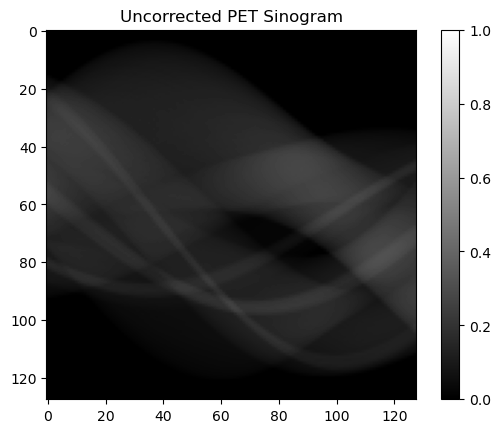

C:\Users\melis\AppData\Local\Temp\ipykernel_13816\2505924172.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pet_projections_processed.append(torch.tensor(pet_sinogram_noisy, dtype=torch.float32, device=device))


In [ ]:
# Dataset 
class PETCTDataset(Dataset):
    def __init__(self, num_samples=num_samples, img_size = image_size):
        self.num_samples = num_samples
        self.img_size = img_size
        self.pet_images = []
        self.ct_images = []
        self.pet_projections_clean = []  
        self.ct_projections_clean = []
        self.pet_projections_processed = []  # Store processed PET projections
        self.ct_projections_processed = []  # Store noisy CT projections

        for _ in range(num_samples):
            
            pet_image, pet_segmentation = generate_pet_image() 
            pet_with_tumors, uppdate_segmentation = add_tumors(pet_image,pet_segmentation,num_tumors=3)
          
            ct_image = generate_ct_image(pet_segmentation)
          
            attenuation_map = ct_to_attenuation(ct_image)
            pet_sinogram_corrected = apply_attenuation_correction(pet_with_tumors,attenuation_map)
          
            pet_sinogram_clean, pet_image  = normalize_together(pet_sinogram_corrected,pet_with_tumors)

            pet_sinogram_contamin = add_contamination(pet_sinogram_clean,contamination_factor=0.1)
            pet_sinogram_blurred = apply_blurring(pet_sinogram_contamin,sigma= 1.5)
            pet_sinogram_noisy = add_poisson_noise(pet_sinogram_blurred,scale_factor=1000)
            

            
            #pet_sinogram_noisy = normalize(pet_sinogram_noisy,pet_sinogram_corrected)           
            
            ct_image = normalize(ct_image)
            ct_sinogram_clean = proj(ct_image)
            ct_sinogram_noisy = add_poisson_noise_ct(ct_sinogram_clean,scale_factor=  5000)
            ct_sinogram_clean = normalize(ct_sinogram_clean)
            ct_sinogram_noisy = normalize(ct_sinogram_noisy)
            
            projection_corrected,projection_not_corrected = normalize_together(pet_sinogram_corrected,proj(pet_with_tumors)) 
            
            plt.imshow(projection_not_corrected, cmap="gray", vmin=0, vmax=1)
            plt.title("Uncorrected PET Sinogram")
            plt.colorbar()
            plt.show()
        
            # Store results
            self.pet_images.append(pet_image)
            self.ct_images.append(ct_image)
            self.pet_projections_clean.append(torch.tensor(pet_sinogram_clean, dtype=torch.float32, device=device))
            self.ct_projections_clean.append(torch.tensor(ct_sinogram_clean, dtype=torch.float32, device=device))
            self.pet_projections_processed.append(torch.tensor(pet_sinogram_noisy, dtype=torch.float32, device=device))
            self.ct_projections_processed.append(torch.tensor(ct_sinogram_noisy, dtype=torch.float32, device=device))
            
            
    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return (
            self.pet_images[idx],              
            self.ct_images[idx],                   
            self.pet_projections_clean[idx],   
            self.ct_projections_clean[idx],  
            self.pet_projections_processed[idx],       
            self.ct_projections_processed[idx],        
            
        )

#Create Dataset and DataLoader
set_random_seed(1)
dataset = PETCTDataset(num_samples=5000) # Set the sample size 
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)



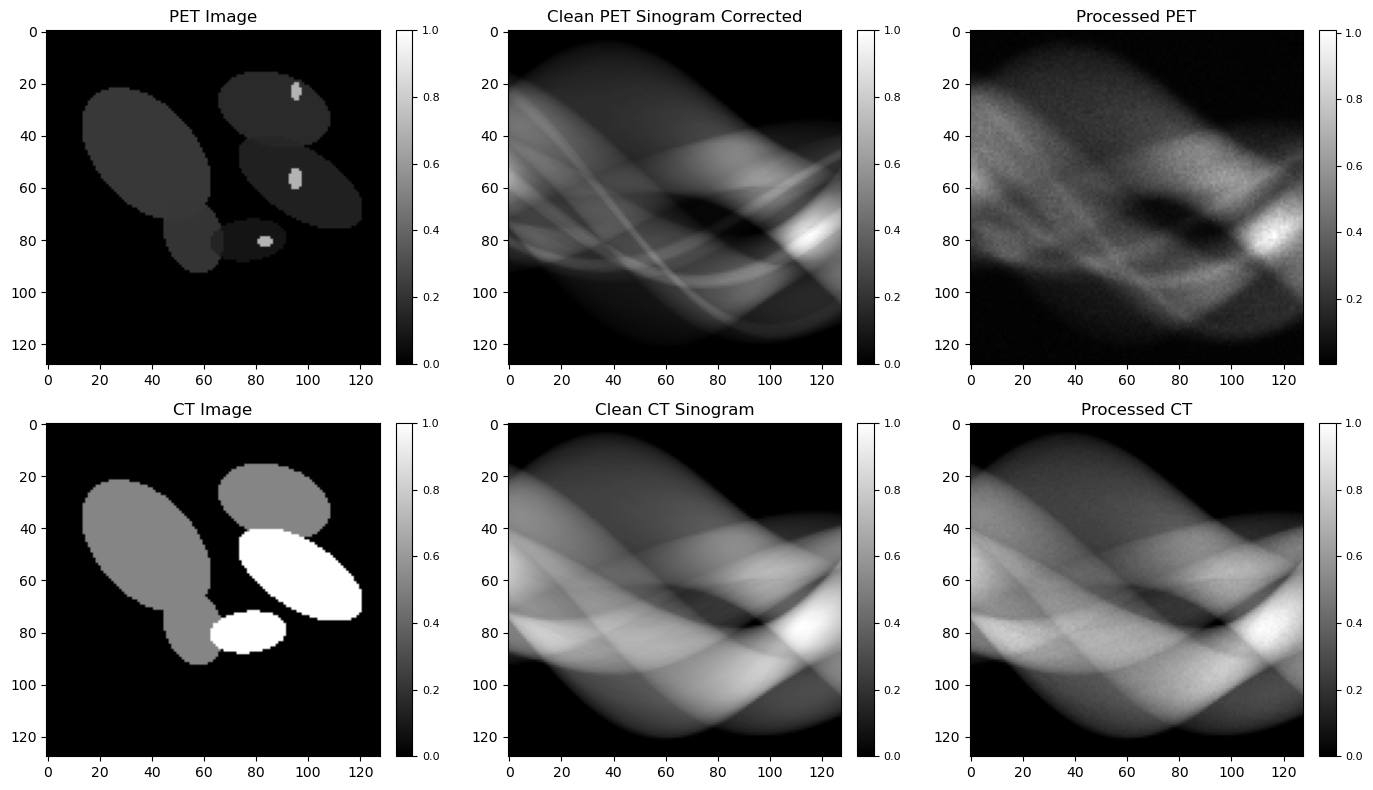

In [12]:
# Visualize first sample 
pet_sample, ct_sample, pet_sinogram_clean, ct_sinogram_clean, processed_pet, processed_ct = dataset[0]

fig, ax = plt.subplots(2, 3, figsize=(14, 8))

# Function to add colorbar with fixed limits
def add_colorbar(im, ax):
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  # Adjust font size


# Set vmin=0, vmax=1 to normalize all images correctly
im0 = ax[0, 0].imshow(pet_sample, cmap="gray",vmin=0, vmax=1)
ax[0, 0].set_title("PET Image")
add_colorbar(im0, ax[0, 0])

im1 = ax[0, 1].imshow(pet_sinogram_clean, cmap="gray")
ax[0, 1].set_title("Clean PET Sinogram Corrected")
add_colorbar(im1, ax[0, 1])

im2 = ax[0, 2].imshow(processed_pet, cmap="gray")
ax[0, 2].set_title("Processed PET")
add_colorbar(im2, ax[0, 2])

im3 = ax[1, 0].imshow(ct_sample, cmap="gray", vmin=0, vmax=1)
ax[1, 0].set_title("CT Image")
add_colorbar(im3, ax[1, 0])

im4 = ax[1, 1].imshow(ct_sinogram_clean, cmap="gray", vmin=0, vmax=1)
ax[1, 1].set_title("Clean CT Sinogram")
add_colorbar(im4, ax[1, 1])

im5 = ax[1, 2].imshow(processed_ct, cmap="gray", vmin=0, vmax=1)
ax[1, 2].set_title("Processed CT")
add_colorbar(im5, ax[1, 2])

plt.tight_layout()
plt.show()